In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

Global seed set to 0


In [2]:
pip install typing-extensions

Note: you may need to restart the kernel to use updated packages.


In [2]:
%config InlineBackend.figure_format = 'retina'

In [115]:
from os import makedirs
from os.path import exists

results_folder = './kidney/results/003_UUO_SH045/'
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

if not exists(ref_run_name):
    makedirs(ref_run_name)
if not exists(run_name):
    makedirs(run_name)

In [2]:
adata_vis = sc.read_visium('/home/jovyan/brain/kidney/003_UUO_SH045/outs/',
                      count_file='/home/jovyan/brain/kidney/003_UUO_SH045/outs/filtered_feature_bc_matrix.h5',
                      source_image_path='/home/jovyan/brain/kidney/003_UUO_SH045/A1_10x_stitch.tif')
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
adata_vis.var.head()

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


gene_ids    feature_types genome
Xkr4     ENSMUSG00000051951  Gene Expression   mm10
Gm1992   ENSMUSG00000089699  Gene Expression   mm10
Gm19938  ENSMUSG00000102331  Gene Expression   mm10
Gm37381  ENSMUSG00000102343  Gene Expression   mm10
Rp1      ENSMUSG00000025900  Gene Expression   mm10

In [3]:
adata_vis

AnnData object with n_obs × n_vars = 790 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var

gene_ids    feature_types genome      SYMBOL
Xkr4        ENSMUSG00000051951  Gene Expression   mm10        Xkr4
Gm1992      ENSMUSG00000089699  Gene Expression   mm10      Gm1992
Gm19938     ENSMUSG00000102331  Gene Expression   mm10     Gm19938
Gm37381     ENSMUSG00000102343  Gene Expression   mm10     Gm37381
Rp1         ENSMUSG00000025900  Gene Expression   mm10         Rp1
...                        ...              ...    ...         ...
AC124606.1  ENSMUSG00000095523  Gene Expression   mm10  AC124606.1
AC133095.2  ENSMUSG00000095475  Gene Expression   mm10  AC133095.2
AC133095.1  ENSMUSG00000094855  Gene Expression   mm10  AC133095.1
AC234645.1  ENSMUSG00000095019  Gene Expression   mm10  AC234645.1
AC149090.1  ENSMUSG00000095041  Gene Expression   mm10  AC149090.1

[32285 rows x 4 columns]

In [5]:
adata_vis.obsm['spatial']=adata_vis.obsm['spatial'].astype('float')

In [6]:
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [7]:
adata_vis.var
adata_vis.var_names_make_unique()

In [8]:
adata_vis.X.todense()[20:30, 30:40]

matrix([[0., 0., 1., 0., 1., 0., 0., 0., 2., 2.],
        [2., 0., 1., 0., 2., 2., 0., 0., 4., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 6., 0., 0., 0., 2., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 4., 0., 0., 0., 4., 1.],
        [0., 0., 0., 0., 3., 1., 0., 0., 3., 1.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 3., 1., 0., 0., 5., 0.]], dtype=float32)

In [10]:
## remove MT genes
adata_vis.var['MT_gene'] = [gene.startswith('mt-') for gene in adata_vis.var['SYMBOL']]
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [11]:
adata_ref = sc.read(f'/home/jovyan/brain/kidney/UUOVH_vs_UUOIH_raw.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 19788 × 20869
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.005_144', 'DF.classifications_0.25_0.005_144', 'Doublets', 'pANN_0.25_0.01_132', 'DF.classifications_0.25_0.01_132', 'pANN_0.25_0.005_147', 'DF.classifications_0.25_0.005_147', 'pANN_0.25_0.01_108', 'DF.classifications_0.25_0.01_108', 'pANN_0.25_0.26_124', 'DF.classifications_0.25_0.26_124', 'pANN_0.25_0.08_117', 'DF.classifications_0.25_0.08_117', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'group', 'customclassif', 'cell_type', 'cell_type2', 'NC'
    var: 'gene_id', 'symbol'

In [12]:
adata_ref.X[20:30, 30:40]

array([[0., 0., 0., 0., 0., 0., 0., 3., 0., 0.],
       [0., 3., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [13]:
adata_ref.obs

orig.ident  nCount_RNA  nFeature_RNA   
AACACACAGAACGTCCAATCCTAAGCC_1     UUOVH1      3251.0          1625  \
AACACACAGAATCCGGTGCCAAGGATG_1     UUOVH1     17083.0          4242   
AACACACAGACACCAACGGTCCTGGTA_1     UUOVH1      2535.0          1042   
AACACACAGACCTGCTACTCCAGTTAG_1     UUOVH1      4604.0          1740   
AACACACAGAGCATAGCGGTAAGATCG_1     UUOVH1      2395.0          1094   
...                                  ...         ...           ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6     UUOIH3     16716.0          4619   
TGTGGACACTATAGCGGTGGCGGATAA_6     UUOIH3      2667.0          1067   
TGTGGACACTCTTCTCAGCCGAGATGT_6     UUOIH3      2368.0          1240   
TGTGGACACTGACTTCCGACCTGAAGG_6     UUOIH3      9195.0          3027   
TGTGGACACTGACTTCCGAGAATGACC_6     UUOIH3      2856.0          1134   

                               percent.mt RNA_snn_res.0.5 seurat_clusters   
AACACACAGAACGTCCAATCCTAAGCC_1    2.983697              14              16  \
AACACACAGAATCCGGTGCCAAGGATG_1    2.487853               5               5   
AACACACAGACACCAACGGTCCTGGTA_1    1.065089               0               1   
AACACACAGACCTGCTACTCCAGTTAG_1    1.672459               0               4   
AACACACAGAGCATAGCGGTAAGATCG_1    2.588727               0               1   
...                                   ...             ...             ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6    5.605408               3               2   
TGTGGACACTATAGCGGTGGCGGATAA_6    2.399700               5               6   
TGTGGACACTCTTCTCAGCCGAGATGT_6    2.829392               7              16   
TGTGGACACTGACTTCCGACCTGAAGG_6    3.719413               4              15   
TGTGGACACTGACTTCCGAGAATGACC_6    2.976190               0               0   

                               pANN_0.25_0.005_144   
AACACACAGAACGTCCAATCCTAAGCC_1                 0.12  \
AACACACAGAATCCGGTGCCAAGGATG_1                 0.08   
AACACACAGACACCAACGGTCCTGGTA_1                 0.00   
AACACACAGACCTGCTACTCCAGTTAG_1                 0.24   
AACACACAGAGCATAGCGGTAAGATCG_1                 0.00   
...                                            ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6                  NaN   
TGTGGACACTATAGCGGTGGCGGATAA_6                  NaN   
TGTGGACACTCTTCTCAGCCGAGATGT_6                  NaN   
TGTGGACACTGACTTCCGACCTGAAGG_6                  NaN   
TGTGGACACTGACTTCCGAGAATGACC_6                  NaN   

                              DF.classifications_0.25_0.005_144 Doublets   
AACACACAGAACGTCCAATCCTAAGCC_1                           Singlet  Singlet  \
AACACACAGAATCCGGTGCCAAGGATG_1                           Singlet  Singlet   
AACACACAGACACCAACGGTCCTGGTA_1                           Singlet  Singlet   
AACACACAGACCTGCTACTCCAGTTAG_1                           Singlet  Singlet   
AACACACAGAGCATAGCGGTAAGATCG_1                           Singlet  Singlet   
...                                                         ...      ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6                                NA  Singlet   
TGTGGACACTATAGCGGTGGCGGATAA_6                                NA  Singlet   
TGTGGACACTCTTCTCAGCCGAGATGT_6                                NA  Singlet   
TGTGGACACTGACTTCCGACCTGAAGG_6                                NA  Singlet   
TGTGGACACTGACTTCCGAGAATGACC_6                                NA  Singlet   

                               pANN_0.25_0.01_132  ... pANN_0.25_0.08_117   
AACACACAGAACGTCCAATCCTAAGCC_1                 NaN  ...                NaN  \
AACACACAGAATCCGGTGCCAAGGATG_1                 NaN  ...                NaN   
AACACACAGACACCAACGGTCCTGGTA_1                 NaN  ...                NaN   
AACACACAGACCTGCTACTCCAGTTAG_1                 NaN  ...                NaN   
AACACACAGAGCATAGCGGTAAGATCG_1                 NaN  ...                NaN   
...                                           ...  ...                ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6                 NaN  ...           0.334375   
TGTGGACACTATAGCGGTGGCGGATAA_6                 NaN  ...           0.221875   
TGTGGACAC

In [14]:
adata_ref.var.index =  adata_ref.var['gene_id']

In [15]:
adata_ref.var.index = adata_ref.var.index.astype(str)

In [16]:
adata_ref.var_names_make_unique()

In [17]:
adata_ref.obs['cell_type2'].unique()

['Endo_Vein', 'Distal tubule cells', 'Inflammatory_cells', 'Proximal tubule cells', 'Principal cells (Collecting duct system)', ..., 'Endo_LargeArtery', 'F4', 'F1', 'Endo_Unknow', 'F2']
Length: 17
Categories (17, object): ['Distal tubule cells', 'Endo_CapillaryArterial', 'Endo_LargeArtery', 'Endo_Unknow', ..., 'Loop of Henle cells', 'Principal cells (Collecting duct system)', 'Proximal tubule cells', 'Unknown']

In [18]:
adata_ref.var

gene_id   symbol
gene_id                                        
ENSMUSG00000000001  ENSMUSG00000000001    Gnai3
ENSMUSG00000000028  ENSMUSG00000000028    Cdc45
ENSMUSG00000000037  ENSMUSG00000000037    Scml2
ENSMUSG00000000049  ENSMUSG00000000049     Apoh
ENSMUSG00000000056  ENSMUSG00000000056     Narf
...                                ...      ...
ENSMUSG00000097917  ENSMUSG00000097917  Gm26839
ENSMUSG00000099568  ENSMUSG00000099568  Gm28513
ENSMUSG00000109609  ENSMUSG00000109609   Gm4972
ENSMUSG00000112461  ENSMUSG00000112461  Gm47625
ENSMUSG00000114110  ENSMUSG00000114110  Gm46379

[20869 rows x 2 columns]

In [36]:
adata_ref.write("/home/jovyan/brain/kidney/UUOVH_vs_UUOIH_raw.h5ad")

In [19]:
adata_ref=adata_ref[(adata_ref.obs['group']=='UUOIH')]

In [20]:
adata_ref.obs

orig.ident  nCount_RNA  nFeature_RNA   
AACACACAGAACGCTAGTGGAGAGGAA_4     UUOIH1      2655.0          1330  \
AACACACAGAACGCTAGTTTAAGAGGC_4     UUOIH1      2651.0          1174   
AACACACAGACCAGGTCAGAGATAGGA_4     UUOIH1      3755.0          1838   
AACACACAGACCTCGACTGAGTGATCT_4     UUOIH1      6403.0          1988   
AACACACAGAGACGAAGTCGTGGCTAT_4     UUOIH1      2499.0          1377   
...                                  ...         ...           ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6     UUOIH3     16716.0          4619   
TGTGGACACTATAGCGGTGGCGGATAA_6     UUOIH3      2667.0          1067   
TGTGGACACTCTTCTCAGCCGAGATGT_6     UUOIH3      2368.0          1240   
TGTGGACACTGACTTCCGACCTGAAGG_6     UUOIH3      9195.0          3027   
TGTGGACACTGACTTCCGAGAATGACC_6     UUOIH3      2856.0          1134   

                               percent.mt RNA_snn_res.0.5 seurat_clusters   
AACACACAGAACGCTAGTGGAGAGGAA_4    2.975518               9              16  \
AACACACAGAACGCTAGTTTAAGAGGC_4    1.622029               0               0   
AACACACAGACCAGGTCAGAGATAGGA_4    6.604527               6               8   
AACACACAGACCTCGACTGAGTGATCT_4    1.155708               8               9   
AACACACAGAGACGAAGTCGTGGCTAT_4    4.601841               9              16   
...                                   ...             ...             ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6    5.605408               3               2   
TGTGGACACTATAGCGGTGGCGGATAA_6    2.399700               5               6   
TGTGGACACTCTTCTCAGCCGAGATGT_6    2.829392               7              16   
TGTGGACACTGACTTCCGACCTGAAGG_6    3.719413               4              15   
TGTGGACACTGACTTCCGAGAATGACC_6    2.976190               0               0   

                               pANN_0.25_0.005_144   
AACACACAGAACGCTAGTGGAGAGGAA_4                  NaN  \
AACACACAGAACGCTAGTTTAAGAGGC_4                  NaN   
AACACACAGACCAGGTCAGAGATAGGA_4                  NaN   
AACACACAGACCTCGACTGAGTGATCT_4                  NaN   
AACACACAGAGACGAAGTCGTGGCTAT_4                  NaN   
...                                            ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6                  NaN   
TGTGGACACTATAGCGGTGGCGGATAA_6                  NaN   
TGTGGACACTCTTCTCAGCCGAGATGT_6                  NaN   
TGTGGACACTGACTTCCGACCTGAAGG_6                  NaN   
TGTGGACACTGACTTCCGAGAATGACC_6                  NaN   

                              DF.classifications_0.25_0.005_144 Doublets   
AACACACAGAACGCTAGTGGAGAGGAA_4                                NA  Singlet  \
AACACACAGAACGCTAGTTTAAGAGGC_4                                NA  Singlet   
AACACACAGACCAGGTCAGAGATAGGA_4                                NA  Singlet   
AACACACAGACCTCGACTGAGTGATCT_4                                NA  Singlet   
AACACACAGAGACGAAGTCGTGGCTAT_4                                NA  Singlet   
...                                                         ...      ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6                                NA  Singlet   
TGTGGACACTATAGCGGTGGCGGATAA_6                                NA  Singlet   
TGTGGACACTCTTCTCAGCCGAGATGT_6                                NA  Singlet   
TGTGGACACTGACTTCCGACCTGAAGG_6                                NA  Singlet   
TGTGGACACTGACTTCCGAGAATGACC_6                                NA  Singlet   

                               pANN_0.25_0.01_132  ... pANN_0.25_0.08_117   
AACACACAGAACGCTAGTGGAGAGGAA_4                 NaN  ...                NaN  \
AACACACAGAACGCTAGTTTAAGAGGC_4                 NaN  ...                NaN   
AACACACAGACCAGGTCAGAGATAGGA_4                 NaN  ...                NaN   
AACACACAGACCTCGACTGAGTGATCT_4                 NaN  ...                NaN   
AACACACAGAGACGAAGTCGTGGCTAT_4                 NaN  ...                NaN   
...                                           ...  ...                ...   
TGTGGACACTAGCGATGAAGGTTGGCT_6                 NaN  ...           0.334375   
TGTGGACACTATAGCGGTGGCGGATAA_6                 NaN  ...           0.221875   
TGTGGACAC

/opt/conda/lib/python3.10/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


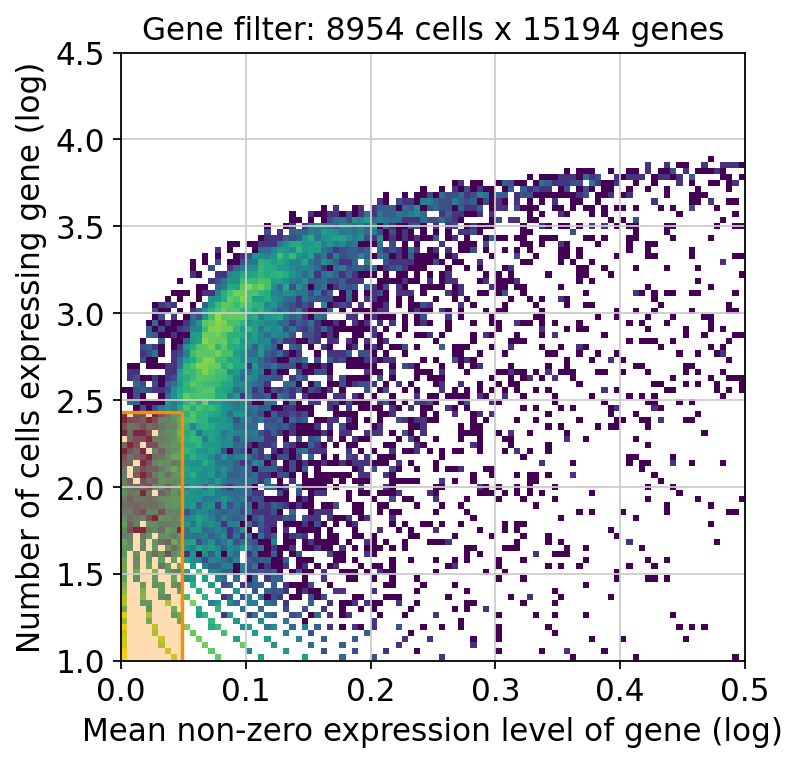

In [21]:
from cell2location.utils.filtering import filter_genes


selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [22]:
from cell2location.models import RegressionModel

cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                                                   batch_key='orig.ident',
                                                   labels_key='cell_type2',
                                                   categorical_covariate_keys=['group'],
                                                   continuous_covariate_keys=None
                                                  )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [23]:
adata_ref.obs[['orig.ident', 'customclassif', 'group']].head()

orig.ident   
AACACACAGAACGCTAGTGGAGAGGAA_4     UUOIH1  \
AACACACAGAACGCTAGTTTAAGAGGC_4     UUOIH1   
AACACACAGACCAGGTCAGAGATAGGA_4     UUOIH1   
AACACACAGACCTCGACTGAGTGATCT_4     UUOIH1   
AACACACAGAGACGAAGTCGTGGCTAT_4     UUOIH1   

                                                             customclassif   
AACACACAGAACGCTAGTGGAGAGGAA_4                            Endothelial cells  \
AACACACAGAACGCTAGTTTAAGAGGC_4                           Inflammatory cells   
AACACACAGACCAGGTCAGAGATAGGA_4  Intercalated cells (Collecting duct system)   
AACACACAGACCTCGACTGAGTGATCT_4                           Inflammatory cells   
AACACACAGAGACGAAGTCGTGGCTAT_4                            Endothelial cells   

                               group  
AACACACAGAACGCTAGTGGAGAGGAA_4  UUOIH  
AACACACAGAACGCTAGTTTAAGAGGC_4  UUOIH  
AACACACAGACCAGGTCAGAGATAGGA_4  UUOIH  
AACACACAGACCTCGACTGAGTGATCT_4  UUOIH  
AACACACAGAGACGAAGTCGTGGCTAT_4  UUOIH

In [24]:
adata_ref

AnnData object with n_obs × n_vars = 8954 × 15194
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.005_144', 'DF.classifications_0.25_0.005_144', 'Doublets', 'pANN_0.25_0.01_132', 'DF.classifications_0.25_0.01_132', 'pANN_0.25_0.005_147', 'DF.classifications_0.25_0.005_147', 'pANN_0.25_0.01_108', 'DF.classifications_0.25_0.01_108', 'pANN_0.25_0.26_124', 'DF.classifications_0.25_0.26_124', 'pANN_0.25_0.08_117', 'DF.classifications_0.25_0.08_117', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'group', 'customclassif', 'cell_type', 'cell_type2', 'NC', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'symbol', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'

In [25]:
adata_ref.obs[['_indices', '_scvi_batch', '_scvi_labels']]

_indices  _scvi_batch  _scvi_labels
AACACACAGAACGCTAGTGGAGAGGAA_4         0            0             2
AACACACAGAACGCTAGTTTAAGAGGC_4         1            0            11
AACACACAGACCAGGTCAGAGATAGGA_4         2            0            12
AACACACAGACCTCGACTGAGTGATCT_4         3            0            11
AACACACAGAGACGAAGTCGTGGCTAT_4         4            0             4
...                                 ...          ...           ...
TGTGGACACTAGCGATGAAGGTTGGCT_6      8949            2            15
TGTGGACACTATAGCGGTGGCGGATAA_6      8950            2            11
TGTGGACACTCTTCTCAGCCGAGATGT_6      8951            2             4
TGTGGACACTGACTTCCGACCTGAAGG_6      8952            2            14
TGTGGACACTGACTTCCGAGAATGACC_6      8953            2            11

[8954 rows x 3 columns]

In [26]:
adata_ref.obs['_scvi_labels'].unique().__len__()

17

In [27]:
# create the regression model
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'cell_type2',
│   'categorical_covariate_keys': ['group'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   3   │
│         n_cells          │ 8954  │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  17   │
│          n_vars          │ 15194 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │   UUOIH1   │          0          │
│                         │   UUOIH2   │          1          │
│                         │   UUOIH3   │          2          │
└─────────────────────────┴────────────┴─────────────────────┘

                                     labels State Registry                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃                 Categories                  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type2'] │             Distal tubule cells             │          0          │
│                         │           Endo_CapillaryArterial            │          1          │
│                         │              Endo_LargeArtery               │          2          │
│                         │                 Endo_Unknow                 │          3          │
│                         │                  Endo_Vein                  │          4          │
│                         │                     F0                      │          5          │
│                         │                     F1                      │          6          │
│                         │                     F2                      │          7          │
│                         │                     F3                      │          8          │
│                         │                     F4                      │          9          │
│                         │                     F5                      │         10          │
│                         │             Inflammatory_cells              │         11          │
│                         │ Intercalated cells (Collecting duct system) │         12          │
│                         │             Loop of Henle cells             │         13          │
│                         │  Principal cells (Collecting duct system)   │         14          │
│                         │            Proximal tubule cells            │         15          │
│                         │                   Unknown                   │         16          │
└─────────────────────────┴─────────────────────────────────────────────┴─────────────────────┘

          extra_categorical_covs State Registry          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['group'] │   UUOIH    │          0          │
│                    │            │                     │
└────────────────────┴────────────┴─────────────────────┘

In [28]:
mod.train(max_epochs=1000, use_gpu=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (4) is s

Epoch 1000/1000: 100%|██████████| 1000/1000 [05:15<00:00,  3.16it/s, v_num=1, elbo_train=4.86e+7]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s, v_num=1, elbo_train=4.86e+7]


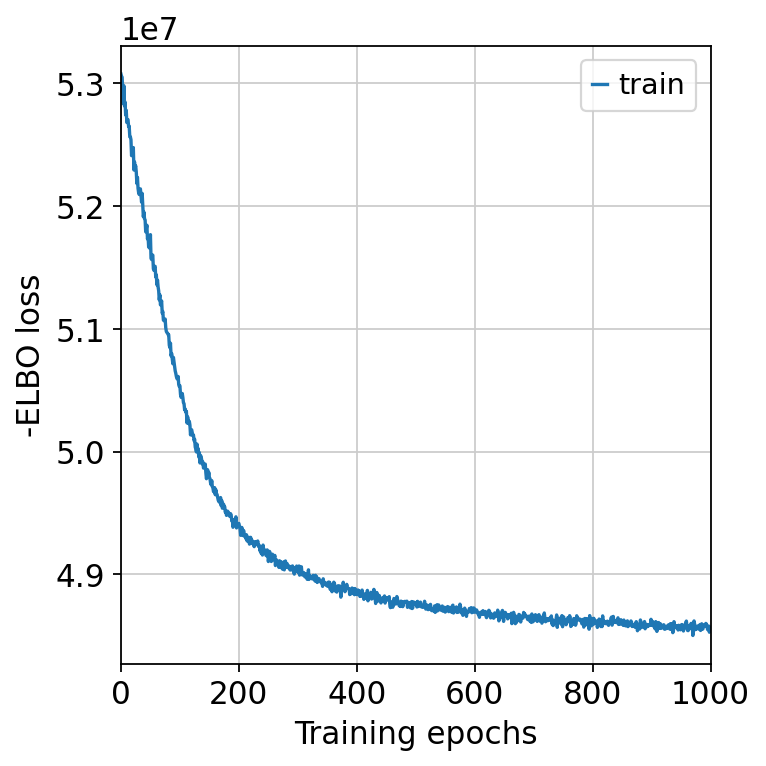

In [29]:
mod.plot_history(0)

In [30]:
### source code links
# export_posterior
# https://github.com/BayraktarLab/cell2location/blob/36e4f007e8fba4cb85c13b9bff47a4f6fbae9295/cell2location/models/reference/_reference_model.py#L186
# sample_posterior
# https://github.com/scverse/scvi-tools/blob/5674ebccea45281f90d61b5bd91a139ccde2ab59/scvi/model/base/_pyromixin.py#L426
# _posterior_samples_minibatch
# https://github.com/scverse/scvi-tools/blob/5674ebccea45281f90d61b5bd91a139ccde2ab59/scvi/model/base/_pyromixin.py#L327

adata_ref = mod.export_posterior(
    adata_ref,
    sample_kwargs = {'num_samples': 1000, 'batch_size': 2048, 'use_gpu': True},
    export_slot = 'mod',
    add_to_varm = ["means", "stds", "q05", "q95"],
    scale_average_detection = True
)

# Save model
mod.save(f"/home/jovyan/brain/kidney/results/003_UUO_SH045/reference_signatures", overwrite=True)

# Save anndata object with results
adata_file = f"/home/jovyan/brain/kidney/results/003_UUO_SH045/reference_signatures/sc_local.h5ad"
adata_ref.write(adata_file)

Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 142.53it/s]


In [31]:
adata_ref

AnnData object with n_obs × n_vars = 8954 × 15194
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.005_144', 'DF.classifications_0.25_0.005_144', 'Doublets', 'pANN_0.25_0.01_132', 'DF.classifications_0.25_0.01_132', 'pANN_0.25_0.005_147', 'DF.classifications_0.25_0.005_147', 'pANN_0.25_0.01_108', 'DF.classifications_0.25_0.01_108', 'pANN_0.25_0.26_124', 'DF.classifications_0.25_0.26_124', 'pANN_0.25_0.08_117', 'DF.classifications_0.25_0.08_117', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'group', 'customclassif', 'cell_type', 'cell_type2', 'NC', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'symbol', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: '_scvi_extra_categorical_covs'
    varm: 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'

In [32]:
adata_ref.uns['mod'].keys()

dict_keys(['model_name', 'date', 'factor_filter', 'factor_names', 'var_names', 'obs_names', 'post_sample_means', 'post_sample_stds', 'post_sample_q05', 'post_sample_q95'])

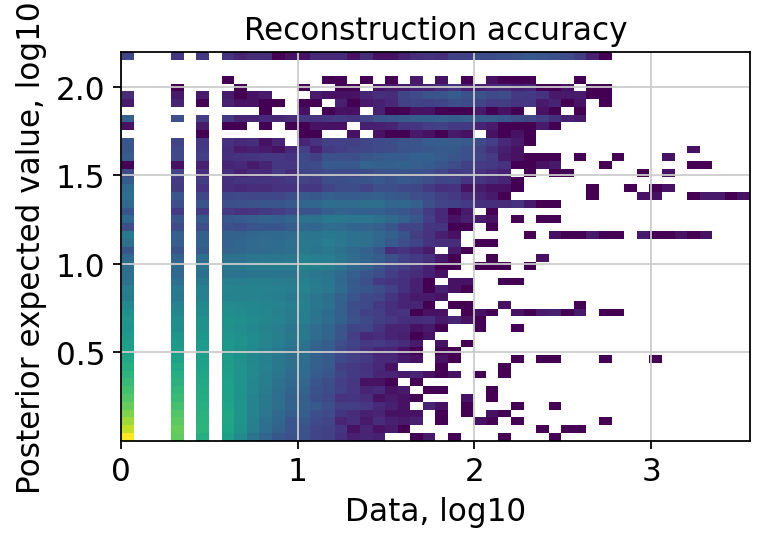

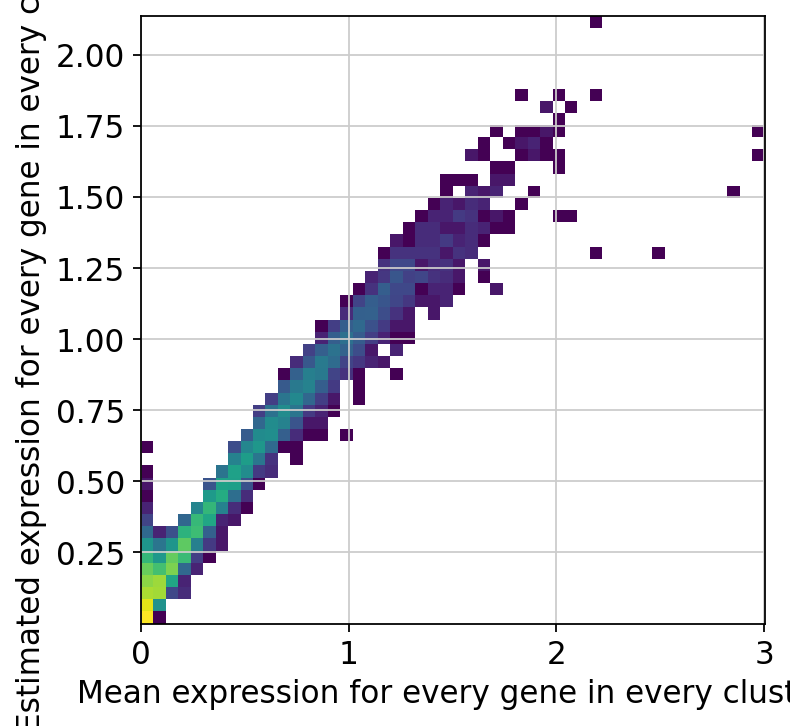

In [33]:
mod.plot_QC()

In [34]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Distal tubule cells  Endo_CapillaryArterial   
gene_id                                                           
ENSMUSG00000000001             0.774382                0.596731  \
ENSMUSG00000000028             0.024942                0.091292   
ENSMUSG00000000037             0.110358                0.582278   
ENSMUSG00000000049             0.032429                0.430423   
ENSMUSG00000000056             0.178087                0.097247   

                    Endo_LargeArtery  Endo_Unknow  Endo_Vein  
gene_id                                                       
ENSMUSG00000000001          0.783282     0.734508   0.716724  
ENSMUSG00000000028          0.264039     0.430499   0.050546  
ENSMUSG00000000037          0.630427     0.505672   0.475632  
ENSMUSG00000000049          0.606567     0.676391   0.169082  
ENSMUSG00000000056          0.247300     0.367526   0.128888

In [35]:
inf_aver.to_csv(f"/home/jovyan/brain/kidney/results/003_UUO_SH045/reference_signatures/inf_aver.csv")

In [37]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
intersect.shape

(14256,)

In [38]:
intersect = np.unique(intersect)
intersect

array(['ENSMUSG00000000001', 'ENSMUSG00000000028', 'ENSMUSG00000000031',
       ..., 'ENSMUSG00000117310', 'ENSMUSG00000117694',
       'ENSMUSG00000118541'], dtype=object)

In [39]:
adata_vis.var_names_make_unique()

In [40]:
adata_vis = adata_vis[:, intersect].copy()

In [41]:
inf_aver = inf_aver.loc[intersect, :].copy()

In [42]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [43]:
adata_vis

AnnData object with n_obs × n_vars = 790 × 14256
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: 'spatial', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial', 'MT'

In [44]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    N_cells_per_location=10,
    detection_alpha=200,  # high technical variability:20; low technical variability:200
    detection_mean_per_sample = False
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │  790  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14256 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃         Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Mouse_Kidney_003_UUO_SH045 │          0          │
└─────────────────────┴────────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [45]:
adata_vis

AnnData object with n_obs × n_vars = 790 × 14256
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: 'spatial', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial', 'MT'

In [46]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is s

Epoch 30000/30000: 100%|██████████| 30000/30000 [21:27<00:00, 24.33it/s, v_num=1, elbo_train=1.22e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [21:27<00:00, 23.29it/s, v_num=1, elbo_train=1.22e+7]


In [47]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"/home/jovyan/brain/kidney/results/003_UUO_SH045/cell2location_map", overwrite=True)

# Save anndata object with results
adata_file = f"/home/jovyan/brain/kidney/results/003_UUO_SH045/cell2location_map/sp_local.h5ad"
adata_vis.write(adata_file)

Sampling global variables, sample: 100%|██████████| 999/999 [00:08<00:00, 113.60it/s]


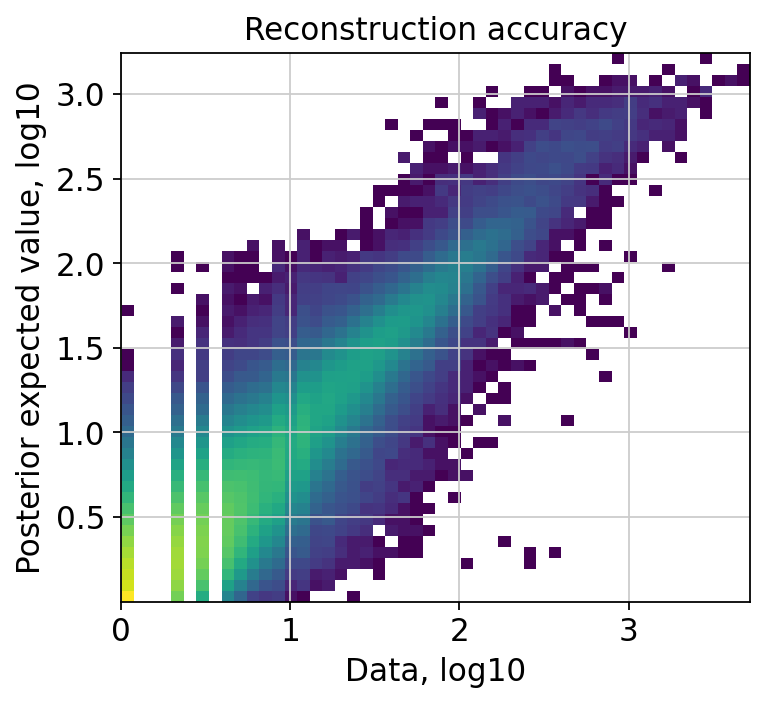

In [48]:
mod.plot_QC()

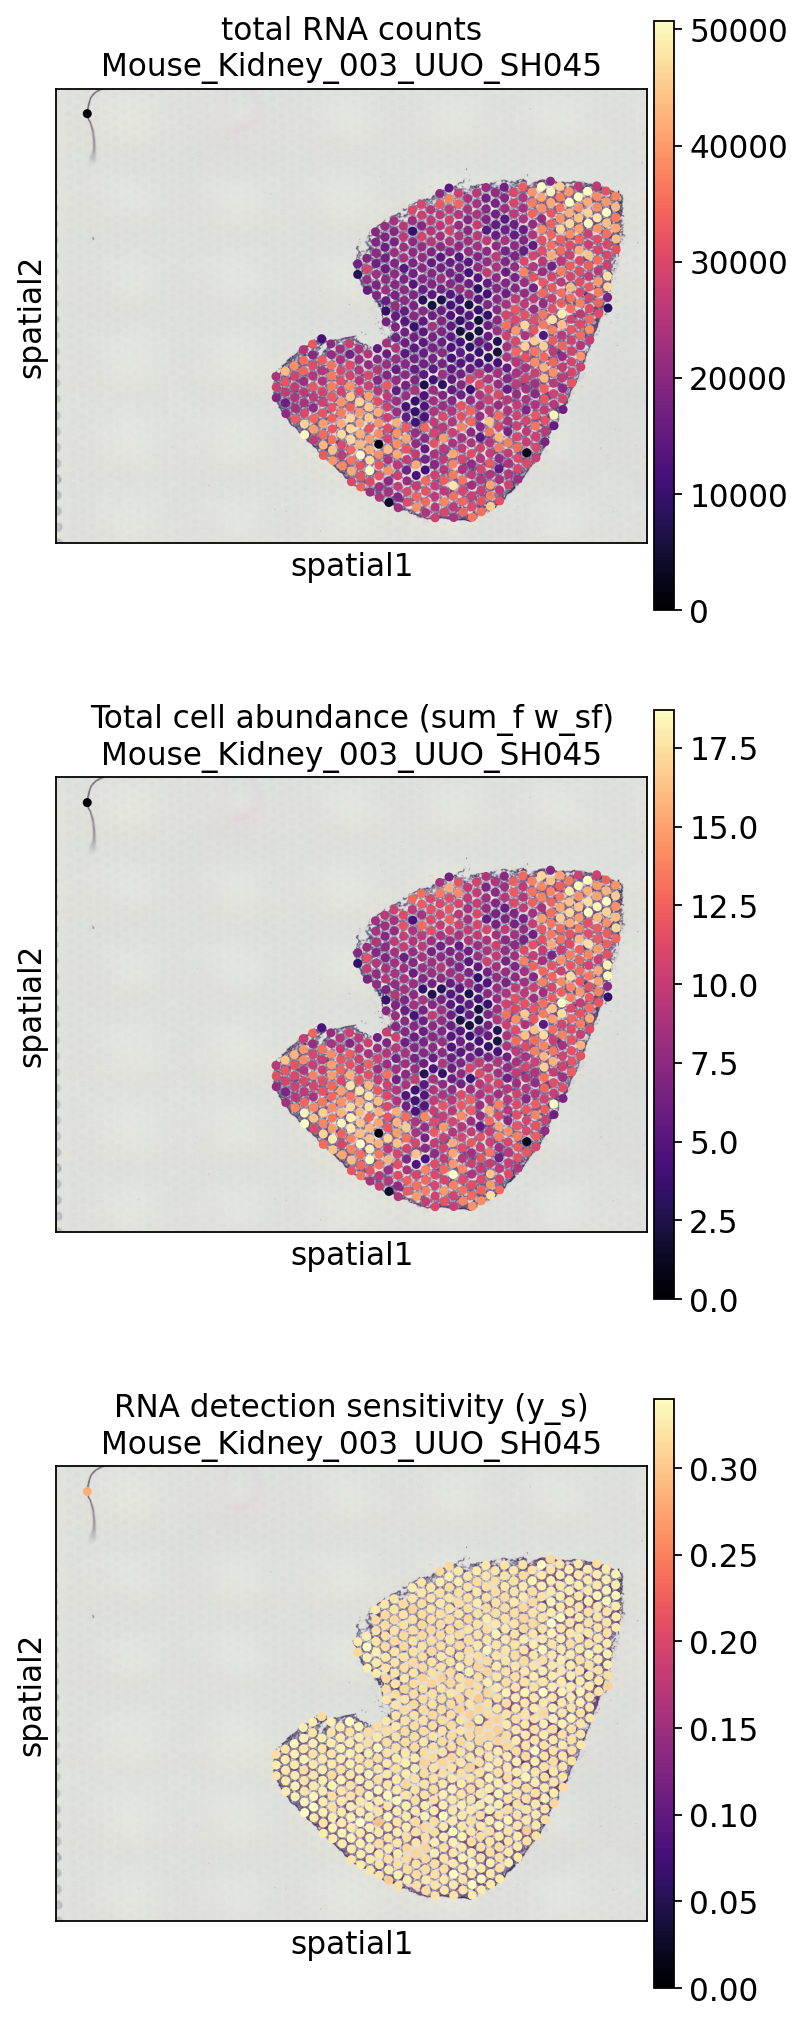

In [49]:
fig = mod.plot_spatial_QC_across_batches()

In [50]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

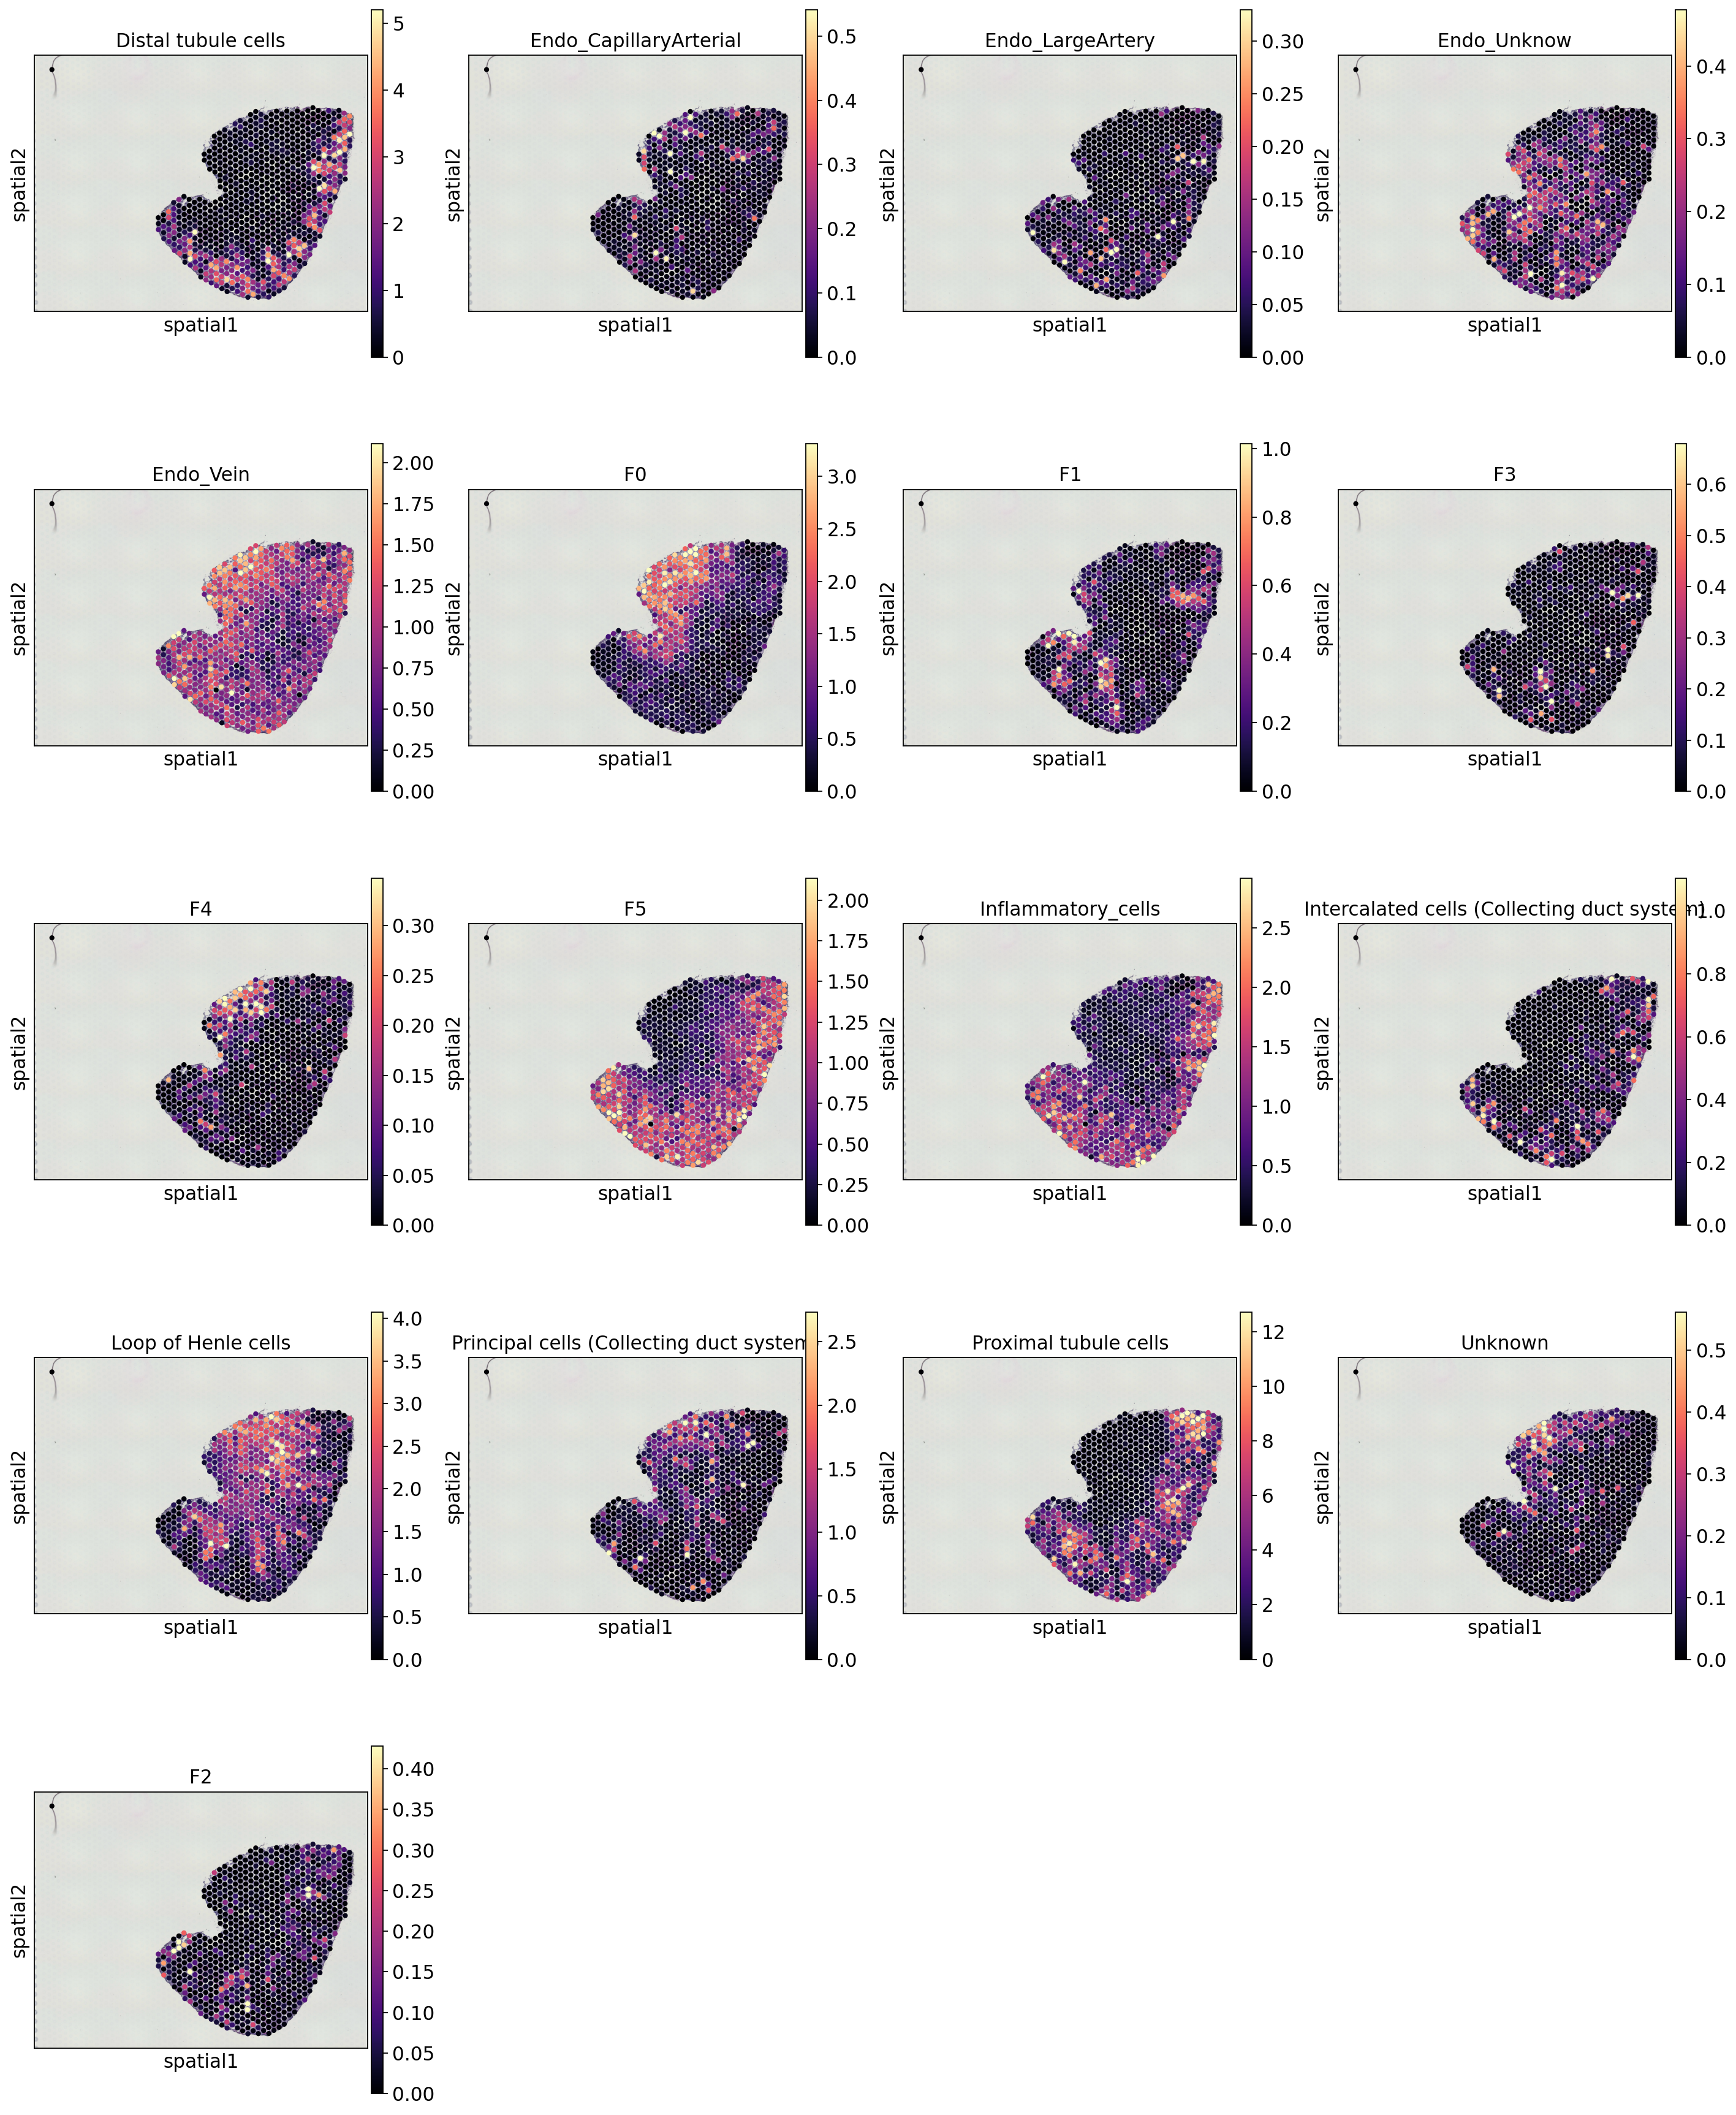

In [ ]:
from cell2location.utils import select_slide
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(adata_vis, cmap='magma',
                  color=['Distal tubule cells','Endo_CapillaryArterial','Endo_LargeArtery','Endo_Unknow','Endo_Vein','F0','F1','F3','F4','F5', 'Inflammatory_cells', 'Intercalated cells (Collecting duct system)', 'Loop of Henle cells', 'Principal cells (Collecting duct system)', 'Proximal tubule cells',  'Unknown','F2'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
expected_dict = mod.module.model.compute_expected_per_cell_type(
    adata_vis.uns['mod']['post_sample_q05'], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

In [ ]:
# Save anndata object with results
adata_file = f"/home/jovyan/brain/kidney/results/003_UUO_SH045/cell2location_map/sp_local.h5ad"
adata_vis.write(adata_file)
adata_file

'/home/jovyan/brain/kidney/results/003_UUO_SH045/cell2location_map/sp_local.h5ad'

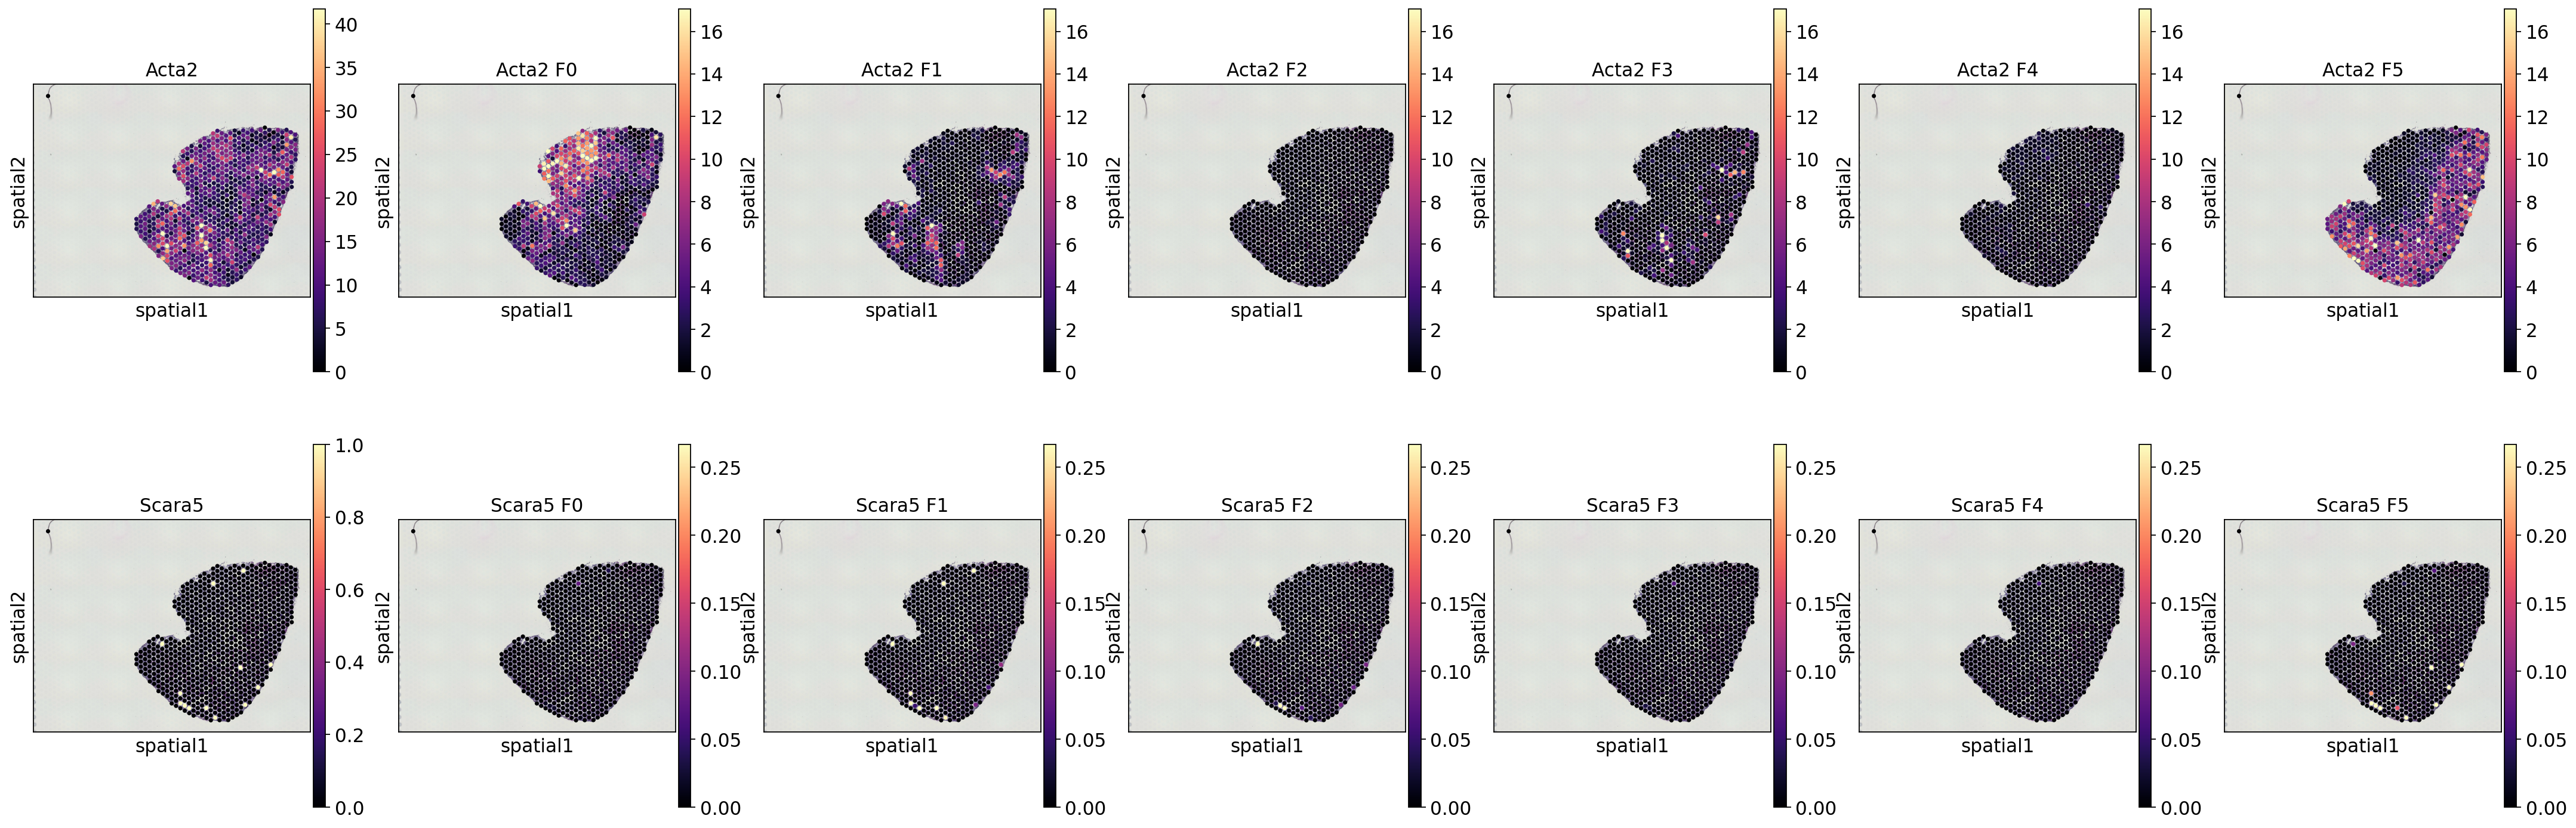

In [ ]:
# list cell types and genes for plotting
ctypes = ['F0','F1','F2','F3','F4','F5']
genes = ['Acta2','Scara5']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis,'Mouse_Kidney_003_UUO_SH045')

    
    plot_genes_per_cell_type(slide, genes, ctypes)
    plt.savefig('gene_in_cell_UUOIH_acta2scara5.pdf');

In [ ]:
cell_types = ['Distal tubule cells','Endo_CapillaryArterial','Endo_LargeArtery','Endo_Unknow','Endo_Vein','F0','F1','F3','F4','F5', 'Inflammatory_cells', 'Intercalated cells (Collecting duct system)', 'Loop of Henle cells', 'Principal cells (Collecting duct system)', 'Proximal tubule cells',  'Unknown','F2']

In [ ]:
prop = adata_vis.obs[cell_types]

cell_expression = []
node_types = []
proportions = []
spatial = []
for i, ct in enumerate(cell_types):
    proportions.append(prop)
    cell_expression.append(adata_vis.layers[ct].toarray())
    nt = np.zeros((prop.shape[0], len(cell_types)))
    nt[:, i] = 1
    node_types.append(nt)
    spatial.append(adata_vis.obsm['spatial'])
    
proportions = pd.DataFrame(np.concatenate(proportions), columns=cell_types)
cell_expression = pd.DataFrame(np.concatenate(cell_expression), columns=adata_vis.var_names)
node_types = pd.DataFrame(np.concatenate(node_types), columns=cell_types)
spatial = pd.DataFrame(np.concatenate(spatial))



In [ ]:
from anndata import AnnData
ad = AnnData(cell_expression)
ad.obsm['proportions'] = np.array(proportions)
ad.obsm['node_types'] = np.array(node_types)
ad.obsm['spatial'] = np.array(spatial)

ad.uns["node_type_names"] = {x: x for x in cell_types}

/tmp/ipykernel_111/1952580824.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = AnnData(cell_expression)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
ad.var_names = adata_vis.var['SYMBOL'].values

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Gnai3', 'Cdc45', 'H19', 'Scml2', 'Apoh']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [ ]:
ad

AnnData object with n_obs × n_vars = 13430 × 14256
    uns: 'node_type_names'
    obsm: 'proportions', 'node_types', 'spatial'

In [ ]:
h_0 = pd.DataFrame(ad.obsm['node_types'], columns=list(ad.uns['node_type_names'].values()))
target_type = pd.DataFrame(np.array(h_0.idxmax(axis=1)), columns=["target_cell"]).reset_index()
ad.obs = target_type

In [ ]:
ad.obs

index          target_cell
0          0  Distal tubule cells
1          1  Distal tubule cells
2          2  Distal tubule cells
3          3  Distal tubule cells
4          4  Distal tubule cells
...      ...                  ...
13425  13425                   F2
13426  13426                   F2
13427  13427                   F2
13428  13428                   F2
13429  13429                   F2

[13430 rows x 2 columns]

In [ ]:
ad.uns['spatial']=adata_vis.uns['spatial']

In [ ]:
fn = f"/home/jovyan/brain/kidney/results/003_UUO_SH045/cell2location_map/deconvolution_result.h5ad"
ad.write(fn)